In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from Target_encoder import target_encoding
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 500)
np.random.seed(77)

# Chargement données

In [3]:
# chargement base de train
df_train = pd.read_csv(
    'train.csv', sep=',',
    low_memory=False,
    error_bad_lines=False)
df_train.drop("id", axis=1, inplace=True)
print(df_train.shape)

# chargement base de test
df_test = pd.read_csv(
    'test.csv', sep=',',
    low_memory=False,
    error_bad_lines=False)
print(df_test.shape)

(25000, 23)
(25000, 23)


# Description et analyse du dataset

In [33]:
df_train.target.value_counts(dropna=False)

0    12077
1     8816
2     3874
3      233
Name: target, dtype: int64

In [4]:
df_train.target.value_counts(normalize=True, dropna=False)

0    0.48308
1    0.35264
2    0.15496
3    0.00932
Name: target, dtype: float64

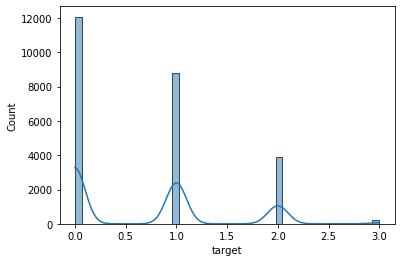

In [5]:
sns.histplot(df_train, x="target", kde=True)

La variable cible contient 4 classes sur le jeu d'entrainement.
Les classes 2 et 3 sont sous representées.
classe 3 : 0.00932 => très rare
classe 2 : 0.15496
Les classes 1 et 2 representent plus du 3/4 du dataset de train.

In [6]:
df_train.dtypes

AP                       object
creation_date_answer     object
situation                 int64
ctc                      object
location                  int64
gc_id                     int64
gc_label                 object
creation_date_global     object
id_group                 object
id_group_2               object
favorite_fruit           object
fruit_situation_id        int64
fruit_situation_label    object
fruits_or_vegetables     object
number_of_fruit           int64
id_group_3               object
creation_date_request    object
hobby                    object
id_group_4               object
ville                    object
green_vegetables         object
vegetable_type           object
target                    int64
dtype: object

Un jeu de données contenant majoritairement des données categorielles

In [7]:
df_train.astype('object').describe().transpose()

,count,unique,top,freq
AP,25000,2,f,24914
creation_date_answer,25000,24278,2019-02-06 09:00:00,10
situation,25000,8,-1,23965
ctc,9620,2,f,8991
location,25000,99,70,1245
gc_id,25000,12,10,13813
gc_label,25000,12,A,13813
creation_date_global,25000,15680,2018-04-25 13:46:28.524,14
id_group,25000,15844,9eac919417ab0,14
id_group_2,25000,15675,12c9978a3bdfb,14


In [8]:
df_train.isnull().sum().sort_values(ascending = False)

vegetable_type           24586
fruits_or_vegetables     17341
ville                    16912
ctc                      15380
fruit_situation_label     1728
target                       0
id_group                     0
creation_date_answer         0
situation                    0
location                     0
gc_id                        0
gc_label                     0
creation_date_global         0
fruit_situation_id           0
id_group_2                   0
favorite_fruit               0
number_of_fruit              0
id_group_3                   0
creation_date_request        0
hobby                        0
id_group_4                   0
green_vegetables             0
AP                           0
dtype: int64

In [9]:
var = 'vegetable_type'
df_train.groupby(var)['target'].agg(['mean', 'count', 'std'])

,mean,count,std
vegetable_type,,,
almostgreen,0.000000,4,0.000000
green,0.832599,227,0.925640
notsogreen,1.171429,35,0.785370
prettygreen,1.300000,10,1.059350
salad,1.007519,133,0.941439
verygreen,1.000000,5,1.000000


In [10]:
df_train.vegetable_type.value_counts(normalize=True, dropna=False)

NaN            0.98344
green          0.00908
salad          0.00532
notsogreen     0.00140
prettygreen    0.00040
verygreen      0.00020
almostgreen    0.00016
Name: vegetable_type, dtype: float64

In [11]:
df_train.groupby('target').agg({'vegetable_type': 'value_counts'})

vegetable_type
target vegetable_type                
0      green                      113
       salad                       53
       notsogreen                   7
       almostgreen                  4
       prettygreen                  3
       verygreen                    2
1      green                       45
       salad                       31
       notsogreen                  16
       prettygreen                  2
       verygreen                    1
2      green                       63
       salad                       44
       notsogreen                  11
       prettygreen                  4
       verygreen                    2
3      green                        6
       salad                        5
       notsogreen                   1
       prettygreen                  1

# Nettoyage des données et création des features

## Gestion des  dates

In [4]:
# fonction pour parser une date
def parsing_date(df, column):
    df[f'day_{column}'] = df[column].dt.day
    df[f'week_{column}'] = df[column].dt.week
    df[f'month_{column}'] = df[column].dt.month
    df[f'year_{column}'] = df[column].dt.year
    df[f'hour_{column}'] = df[column].dt.hour
    df[f'weekday_{column}'] = df[column].dt.weekday
    return df

date_columns = [col for col in df_train.columns if "date" in col]

# fonction pour appliquer les transformations sur base de train et de test
def create_date_columns(df, columns):
    for date_col in columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = parsing_date(df, date_col)
        df.drop(date_col, axis=1, inplace=True)
    return df

df_test= create_date_columns(df_test, date_columns)
df_train= create_date_columns(df_train, date_columns)                    

11:1: E305 expected 2 blank lines after class or function definition, found 1
14:1: E302 expected 2 blank lines, found 1
21:1: E305 expected 2 blank lines after class or function definition, found 1
21:8: E225 missing whitespace around operator
22:9: E225 missing whitespace around operator


## Gestion des données catégorielles

In [5]:
# Identification des variables de type objet.
var_to_encode = df_train.select_dtypes(include=object).columns

In [14]:
var_to_encode

Index(['AP', 'ctc', 'gc_label', 'id_group', 'id_group_2', 'favorite_fruit', 'fruit_situation_label', 'fruits_or_vegetables', 'id_group_3', 'hobby', 'id_group_4', 'ville', 'green_vegetables', 'vegetable_type'], dtype='object')

In [6]:
df_train[var_to_encode].describe().T

,count,unique,top,freq
AP,25000,2,f,24914
ctc,9620,2,f,8991
gc_label,25000,12,A,13813
id_group,25000,15844,9eac919417ab0,14
id_group_2,25000,15675,12c9978a3bdfb,14
favorite_fruit,25000,2,clementine,18147
fruit_situation_label,23272,21,ag,10651
fruits_or_vegetables,7659,2,f,6394
id_group_3,25000,872,fa2eb9a81317a,298
hobby,25000,3,football,24661


#  Encoding

In [6]:
var_to_encode_describe = df_train[var_to_encode].describe().T

In [7]:
# Recuperer dans une variable les noms de variables
# pour lesquelles un one hot encoding sera appliqué
var_to_one_hot = var_to_encode_describe[var_to_encode_describe.unique <= 3].index

In [8]:
# Gestion des données manquantes avec un fillna par la modalité missing.
# Le ohe creera une colonne specifique pour les données manquantes.
# Un modele peut extraire de l'information sur des données non renseignés.

df_train[var_to_one_hot] = df_train[var_to_one_hot].fillna("missing")
df_test[var_to_one_hot] = df_test[var_to_one_hot].fillna("missing")

In [9]:
# application du ohe
drop_enc = OneHotEncoder().fit(df_train[var_to_one_hot])

df_train_ohe = drop_enc.transform(df_train[var_to_one_hot])
df_test_ohe = drop_enc.transform(df_test[var_to_one_hot])

In [10]:
# transformation de la matrice en format dataframe
# concatenation des colonnes encodées
# suppression des variables originales

df_train.drop(var_to_one_hot, axis=1, inplace=True)

df_train_ohe = pd.concat([pd.DataFrame.sparse.from_spmatrix
                          (df_train_ohe,
                           columns=drop_enc.get_feature_names()),
                           df_train],
                        axis=1)

df_test.drop(var_to_one_hot, axis=1, inplace=True)

df_test_ohe = pd.concat([pd.DataFrame.sparse.from_spmatrix
                         (df_test_ohe, 
                        columns=drop_enc.get_feature_names()),
                        df_test], axis=1)




/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
10:28: E127 continuation line over-indented for visual indent
11:25: E128 continuation line under-indented for visual indent
16:39: W291 trailing whitespace
17:25: E128 continuation line under-indented for visual indent


In [21]:
df_train_ohe

,x0_f,x0_t,x1_f,x1_missing,x1_t,x2_clementine,x2_poire,x3_f,x3_missing,x3_t,x4_football,x4_noball,x4_volleyball,x5_f,x5_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,target,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,52,70,G,2d7e206d46ea1,36bac09400660,120,jzy,-1,812a43d710ace,aa8f4934a31eb,NaN,NaN,0,13,11,3,2019,11,2,17,3,1,2019,10,3,13,11,3,2019,11,2
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,78,10,A,35e96d6848871,80a697d593706,10,ae,-1,4b59257f24573,6ff9ea9ec85fd,NaN,NaN,1,21,12,3,2019,14,3,20,34,8,2018,5,0,21,12,3,2019,14,3
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,70,10,A,ffaf8085e383d,c309176b96268,200,ag,-1,f1a838f0d194b,6a49a0a97b049,NaN,NaN,0,15,11,3,2019,17,4,20,51,12,2018,13,3,15,11,3,2019,17,4
3,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,84,10,A,5360cf0a40ce3,13c1a3597648b,10,ae,0,c3196847d1c14,d0dcf1ca1bf04,NaN,NaN,1,7,2,1,2019,8,0,21,29,7,2018,10,5,7,2,1,2019,8,0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,29,20,D,126c3211f23fc,7b68e0a456571,10,ae,-1,70e18c6fe58cd,b4870b1c8eb42,NaN,NaN,1,3,5,2,2019,17,6,7,49,12,2018,19,4,3,5,2,2019,17,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,17,10,A,07d568301bae5,8ed90715244e0,160,zht,-1,7f9b9fe72ad1b,97de0f5d0b0cf,NaN,NaN,0,21,12,3,2019,16,3,16,11,3,2019,10,5,21,12,3,2019,16,3
24996,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,93,10,A,ecf26c2e00203,5f820a5b9c8cd,10,ae,-1,5918a05e76cfe,0aac6e868db10,NaN,NaN,1,15,7,2,2019,21,4,15,37,9,2018,9,5,15,7,2,2019,21,4
24997,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,68,10,A,c84066a550a3a,6532597956225,200,ag,0,50101f6881261,89c8a90e0ce38,NaN,NaN,0,3,1,1,2019,10,3,20,38,9,2018,13,3,3,1,1,2019,10,3
24998,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1,78,20,D,98e8126974bad,8aa3d8d3a97d3,200,ag,0,0f1a3e137c5ea,0157899906f02,Moissy-Cramayel,NaN,1,17,3,1,2019,12,3,4,44,11,2018,17,6,17,3,1,2019,12,3


In [22]:
df_test_ohe

,x0_f,x0_t,x1_f,x1_missing,x1_t,x2_clementine,x2_poire,x3_f,x3_missing,x3_t,x4_football,x4_noball,x4_volleyball,x5_f,x5_t,id,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,cb7a4e0dd0777,30,100,40,B,b6a3d931cbbaf,c9cc8f25f33cd,120,jzy,1,bc3a12cac647f,b78bd3c9f945c,Saint-Leu,NaN,13,11,3,2019,7,2,13,11,3,2019,7,2,13,11,3,2019,7,2
1,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,e78e3915f3e30,-1,95,40,B,1b35749232404,cc429927fe144,50,hetz,1,79aa2c96bd0fc,6fed1653be26d,Créteil,NaN,7,2,1,2019,13,0,18,51,12,2018,18,1,7,2,1,2019,13,0
2,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,8e65ba155f983,-1,34,20,D,8f7612ff2c9cc,cfaf2bb299ac6,200,ag,-1,4b634a698cc8e,fb7b5da2ef839,Bordeaux,NaN,25,4,1,2019,14,4,17,3,1,2018,13,2,25,4,1,2019,14,4
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,701e90ca03ce2,10,45,40,B,2e3620e03b5f3,bf01c06305abb,200,ag,2,cccd30d947857,3a230e52fb02e,Saint-Herblain,NaN,16,3,1,2019,14,2,7,45,11,2018,13,2,16,3,1,2019,14,2
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,768fefec8609a,10,95,100,H,ac19c1e8abd0d,033ec37966b00,50,hetz,2,62769fb7addda,94c376f28ea60,Drancy,NaN,11,7,2,2019,14,0,16,42,10,2018,10,1,11,7,2,2019,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3232bad9c00cc,-1,60,10,A,95a56d824dd8e,3976c9fb3b227,200,ag,0,62f3ff83bc692,cfdfc4bae9d99,NaN,NaN,11,7,2,2019,9,0,8,6,2,2019,15,4,11,7,2,2019,9,0
24996,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,7b178c38ad263,-1,45,10,A,0a862475e1701,e3cb91abc2951,200,ag,-1,cccd30d947857,f3c523cde1292,Nantes,NaN,23,4,1,2019,9,2,18,51,12,2018,11,1,23,4,1,2019,9,2
24997,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,5876ad905d4b4,-1,58,10,A,02d8284246fca,1c8dd807280e2,10,ae,-1,fa2eb9a81317a,c2ac6810f81b5,NaN,NaN,10,10,3,2019,7,6,27,9,2,2019,11,2,10,10,3,2019,7,6
24998,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5921ef2921c68,-1,60,20,D,68fb52f788708,598f3c91c3a8c,200,ag,-1,eefd8c1c28728,aeaa1f918497c,NaN,green,27,9,2,2019,16,2,9,32,8,2018,8,3,27,9,2,2019,16,2


In [11]:
df_test_ohe = df_test_ohe.set_index('id')


# TE

In [12]:
var_to_te = var_to_encode_describe[var_to_encode_describe.unique>3].index

1:65: E225 missing whitespace around operator


In [14]:
var_to_te

Index(['gc_label', 'id_group', 'id_group_2', 'fruit_situation_label', 'id_group_3', 'id_group_4', 'ville', 'vegetable_type'], dtype='object')

# Exemple sur une variable à encoder

In [15]:
prior = df_train.target.mean()
print('Prior (moyenne de la cible à prédire) =', prior)

var = 'gc_label'
df_train.groupby(var)['target'].agg(['mean', 'count', 'std'])

Prior (moyenne de la cible à prédire) = 0.69052


,mean,count,std
gc_label,,,
A,0.644321,13813,0.699465
B,0.912796,2282,0.927359
C,0.506329,948,0.705209
D,0.756357,3854,0.756359
E,0.856209,153,0.764494
F,0.461538,13,0.776250
G,0.487619,525,0.684018
H,0.750674,2226,0.874771
I,0.676829,164,0.813505


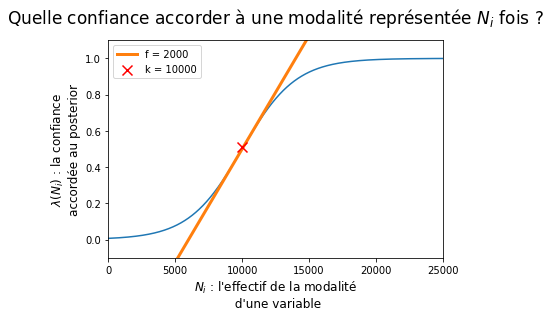

5:37: E128 continuation line under-indented for visual indent
6:37: E128 continuation line under-indented for visual indent
7:37: E128 continuation line under-indented for visual indent
8:37: E128 continuation line under-indented for visual indent
9:37: E128 continuation line under-indented for visual indent
10:37: E128 continuation line under-indented for visual indent


In [16]:
# Application de la fonction target encoding
# Cette fonction a été developpé par un proche
# Fonction testés et utilisés à plusieurs reprises dans des projets
encoding_gc_label, mapping_gc_label = target_encoding(df_train,
                                    serie='gc_label',
                                    target_name='target',
                                    k=10000,
                                    f=2000,
                                    avec_viz=True,
                                    noise_level=0)

In [28]:
#resultat de l'encoding
mapping_gc_label

{'A': 0.6502975992746985,
 'B': 0.6951107763128783,
 'C': 0.6885476870940799,
 'D': 0.6934322892265472,
 'E': 0.6917164587368099,
 'F': 0.6889775340693239,
 'G': 0.6887579188690934,
 'H': 0.6917287734642878,
 'I': 0.6904205965086627,
 'J': 0.685893859698352,
 'K': 0.6903641430867458,
 'L': 0.6906857716546099,
 nan: 0.69052}

In [13]:
te_mapping = {}

for var in var_to_te:
    encoding, mapping = target_encoding(df_train, serie=var, target_name='target', k=10000, f=2000,
                                        avec_viz=False, noise_level=0)
    te_mapping[var]= mapping

4:80: E501 line too long (99 > 79 characters)
6:20: E225 missing whitespace around operator


In [14]:
def build_df_encoding(df, te_mapping):
    for var, mapping in te_mapping.items():
        df[var] = df[var].map(mapping)
    return df

In [15]:
df_train_te = build_df_encoding(df_train_ohe, te_mapping)
df_test_te = build_df_encoding(df_test_ohe,te_mapping)

2:43: E231 missing whitespace after ','


In [32]:
df_train_te.head(3)

,x0_f,x0_t,x1_f,x1_missing,x1_t,x2_clementine,x2_poire,x3_f,x3_missing,x3_t,x4_football,x4_noball,x4_volleyball,x5_f,x5_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,target,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,52,70,0.688758,0.685894,0.685894,120,0.686462,-1,0.685869,0.685894,0.69052,0.69052,0,13,11,3,2019,11,2,17,3,1,2019,10,3,13,11,3,2019,11,2
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,78,10,0.650298,0.692594,0.692594,10,0.751629,-1,0.687839,0.692594,0.69052,0.69052,1,21,12,3,2019,14,3,20,34,8,2018,5,0,21,12,3,2019,14,3
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,70,10,0.650298,0.685892,0.685892,200,0.508120,-1,0.687776,0.685892,0.69052,0.69052,0,15,11,3,2019,17,4,20,51,12,2018,13,3,15,11,3,2019,17,4


In [33]:
df_test_te.head(3)

,x0_f,x0_t,x1_f,x1_missing,x1_t,x2_clementine,x2_poire,x3_f,x3_missing,x3_t,x4_football,x4_noball,x4_volleyball,x5_f,x5_t,situation,location,gc_id,gc_label,id_group,id_group_2,fruit_situation_id,fruit_situation_label,number_of_fruit,id_group_3,id_group_4,ville,vegetable_type,day_creation_date_answer,week_creation_date_answer,month_creation_date_answer,year_creation_date_answer,hour_creation_date_answer,weekday_creation_date_answer,day_creation_date_global,week_creation_date_global,month_creation_date_global,year_creation_date_global,hour_creation_date_global,weekday_creation_date_global,day_creation_date_request,week_creation_date_request,month_creation_date_request,year_creation_date_request,hour_creation_date_request,weekday_creation_date_request
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
cb7a4e0dd0777,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,30,100,40,0.695111,NaN,NaN,120,0.686462,1,0.689312,NaN,0.685889,0.69052,13,11,3,2019,7,2,13,11,3,2019,7,2,13,11,3,2019,7,2
e78e3915f3e30,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,-1,95,40,0.695111,0.695943,0.695943,50,0.706915,1,0.694196,0.695943,0.690957,0.69052,7,2,1,2019,13,0,18,51,12,2018,18,1,7,2,1,2019,13,0
8e65ba155f983,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-1,34,20,0.693432,NaN,NaN,200,0.508120,-1,0.686721,NaN,0.686266,0.69052,25,4,1,2019,14,4,17,3,1,2018,13,2,25,4,1,2019,14,4


# Modelisation

In [18]:
df_train_te.to_csv('df_train_clean.csv',index=False)

1:40: E231 missing whitespace after ','


In [19]:
from sklearn.ensemble import RandomForestClassifier

X = df_train_te.drop('target',axis=1)
y = df_train_te.target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 77, stratify=y)

3:30: E231 missing whitespace after ','
6:1: E402 module level import not at top of file
7:68: E251 unexpected spaces around keyword / parameter equals
7:70: E251 unexpected spaces around keyword / parameter equals
7:88: E251 unexpected spaces around keyword / parameter equals
7:90: E251 unexpected spaces around keyword / parameter equals


# Random Forest classifier

In [31]:
rfc=RandomForestClassifier(random_state=77)

1:4: E225 missing whitespace around operator


In [37]:
%%time
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_grid ={
    'n_estimators': [500,800,1000],
    'max_features':['auto'],
    'max_depth':[5 ,8, 10, 12],
    'criterion':['gini']

}

cv_rfc = RandomizedSearchCV(estimator=rfc,
                         param_distributions=param_grid,
                         scoring='neg_log_loss',
                         n_iter=2,
                         verbose=1,
                        n_jobs = -1)


#cv_rfc = GridSearchCV(rfc, param_grid,cv=10, scoring='neg_log_loss',verbose=1)


CPU times: user 24 µs, sys: 4 µs, total: 28 µs
Wall time: 35.8 µs


In [38]:
cv_rfc 

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=77), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [5, 8, 10, 12],
                                        'max_features': ['auto'],
                                        'n_estimators': [500, 800, 1000]},
                   scoring='neg_log_loss', verbose=1)

In [39]:
10**y_train

9785        1
23011       1
16926      10
12398       1
7075        1
         ... 
17068     100
7515       10
219      1000
2307        1
15159       1
Name: target, Length: 20000, dtype: int64

In [40]:
%%time
cv_rfc.fit(X_train,y_train, sample_weight=10**y_train )

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


CPU times: user 13.7 s, sys: 204 ms, total: 13.9 s
Wall time: 45.4 s


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=77), n_iter=2,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini'],
                                        'max_depth': [5, 8, 10, 12],
                                        'max_features': ['auto'],
                                        'n_estimators': [500, 800, 1000]},
                   scoring='neg_log_loss', verbose=1)

In [41]:
cv_rfc.best_params_

{'n_estimators': 1000,
 'max_features': 'auto',
 'max_depth': 10,
 'criterion': 'gini'}

In [45]:
cv_rfc.best_estimator_

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=77)

In [42]:
from sklearn.metrics import log_loss
rfc1=RandomForestClassifier(random_state=77,**cv_rfc.best_params_)

2:5: E225 missing whitespace around operator
2:44: E231 missing whitespace after ','


In [43]:
rfc1.fit(X_train, y_train, sample_weight=10**y_train )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=77)

1:53: E202 whitespace before ')'


In [44]:
pred_rfc = rfc1.predict(X_test)
preds_rfc_prob = rfc1.predict_proba(X_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:625: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
print(classification_report(pred_rfc, y_test))

1:80: E501 line too long (80 > 79 characters)


              precision    recall  f1-score   support

           0       0.30      1.00      0.46       718
           1       0.55      0.72      0.62      1346
           2       0.95      0.25      0.40      2908
           3       0.23      0.39      0.29        28

    accuracy                           0.49      5000
   macro avg       0.51      0.59      0.44      5000
weighted avg       0.75      0.49      0.47      5000



In [47]:
from sklearn.metrics import log_loss
print("log loss pour RF classifier sur train:",log_loss(y_test,preds_rfc_prob ))

2:47: E231 missing whitespace after ','
2:63: E231 missing whitespace after ','
2:78: E202 whitespace before ')'


log loss pour RF classifier sur train: 1.2685943581309025


In [57]:
 confusion_matrix(pred_rfc, y_test)

array([[ 718,    0,    0,    0],
       [ 348,  971,   27,    0],
       [1346,  787,  739,   36],
       [   3,    5,    9,   11]])

1: E999 IndentationError: unexpected indent
1:2: E111 indentation is not a multiple of four
1:2: E113 unexpected indentation


In [68]:
def plot_feature_importance(df,model):
    
    importances = model.best_estimator_.feature_importances_
    print()
    std = np.std([tree.feature_importances_ for tree in model.best_estimator_.estimators_],axis=0)
    indices = np.argsort(importances)[::-1]
    print(len(indices))
    print(len(df.columns))
    names = [df.columns[i] for i in indices]
    
    # Print the feature ranking
    
    print("Feature ranking:")
    for f in range(X_test.shape[1]):
        print("%d. feature name: %s (%f)" % (f + 1, names[f], importances[indices[f]]))
        
    # Plot the feature importances of the forest
    plt.figure(figsize=(16,12))
    plt.title("Feature importances")
    plt.bar(range(df.shape[1]), importances[indices],color="r", yerr=std[indices], align="center")
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.xlim([-1,df.shape[1]])
    return plt.show()

1:31: E231 missing whitespace after ','
2:1: W293 blank line contains whitespace
5:80: E501 line too long (98 > 79 characters)
5:91: E231 missing whitespace after ','
10:1: W293 blank line contains whitespace
12:1: W293 blank line contains whitespace
15:80: E501 line too long (87 > 79 characters)
16:1: W293 blank line contains whitespace
18:27: E231 missing whitespace after ','
20:53: E231 missing whitespace after ','
20:80: E501 line too long (98 > 79 characters)
22:17: E231 missing whitespace after ','



46
46
Feature ranking:
1. feature name: location (0.128993)
2. feature name: id_group_3 (0.085039)
3. feature name: id_group (0.070668)
4. feature name: id_group_4 (0.068500)
5. feature name: id_group_2 (0.066407)
6. feature name: week_creation_date_global (0.044707)
7. feature name: day_creation_date_global (0.035120)
8. feature name: hour_creation_date_answer (0.033469)
9. feature name: hour_creation_date_request (0.032637)
10. feature name: month_creation_date_global (0.030478)
11. feature name: fruit_situation_label (0.030274)
12. feature name: fruit_situation_id (0.030077)
13. feature name: hour_creation_date_global (0.028849)
14. feature name: day_creation_date_answer (0.028601)
15. feature name: day_creation_date_request (0.028073)
16. feature name: ville (0.023618)
17. feature name: weekday_creation_date_global (0.023538)
18. feature name: weekday_creation_date_request (0.023277)
19. feature name: weekday_creation_date_answer (0.022842)
20. feature name: week_creation_date_req

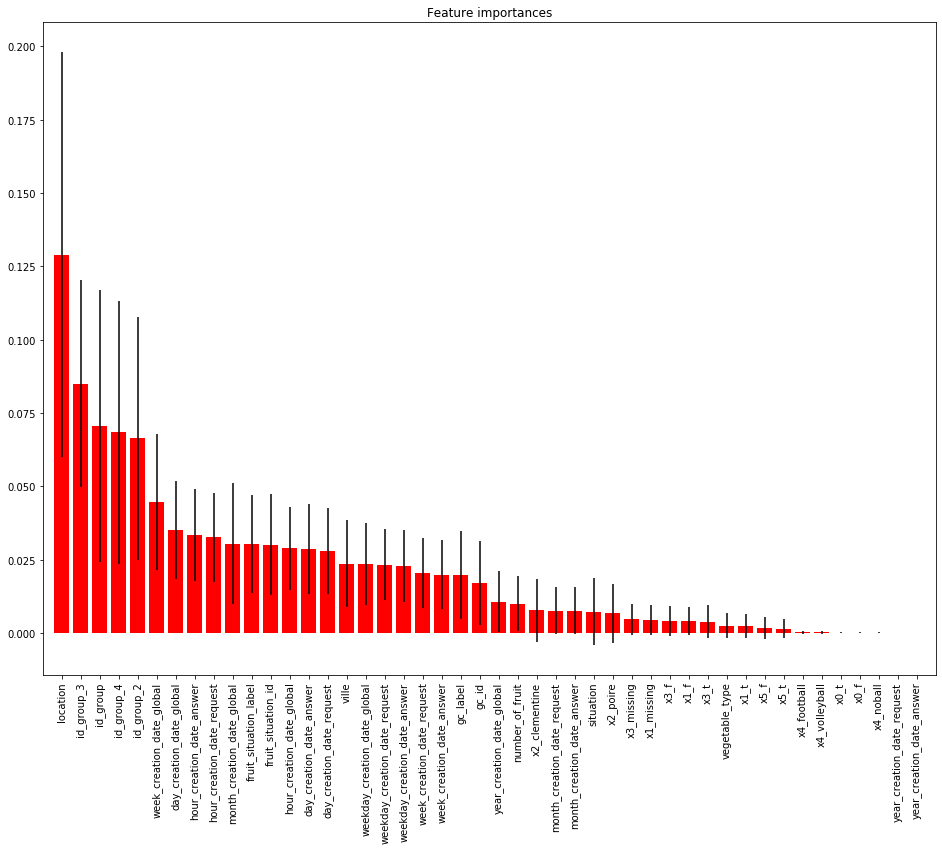

1:32: E231 missing whitespace after ','


In [69]:
plot_feature_importance(X_train,cv_rfc)

# Modele 2 : Xgboost classifieur

In [19]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(objective="multi:softprob",seed=77)

param_grid_xgb = {
    'max_depth': [8 ,12],
    'n_estimators': [500,1000, 1200],
    'learning_rate': [0.1]
    
}



In [22]:
grid_xgb = GridSearchCV(estimator=xgbc,param_grid=param_grid_xgb,scoring='neg_log_loss',cv = 10,verbose=True, n_jobs = -1)

In [20]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(objective="multi:softprob",seed=77)

2:48: E231 missing whitespace after ','


In [21]:
from sklearn.model_selection import RandomizedSearchCV

params = { 'max_depth': [ 8,10],
           'learning_rate': [0.1],
           'n_estimators': [1000,1200]}

cv_clf = RandomizedSearchCV(estimator=xgbc,
                         param_distributions=params,
                         scoring='neg_log_loss',
                         n_iter=5,
                         verbose=1,
                        n_jobs = -1)

3:11: E201 whitespace after '{'
3:26: E201 whitespace after '['
3:28: E231 missing whitespace after ','
5:33: E231 missing whitespace after ','
8:26: E128 continuation line under-indented for visual indent
9:26: E128 continuation line under-indented for visual indent
10:26: E128 continuation line under-indented for visual indent
11:26: E128 continuation line under-indented for visual indent
12:25: E128 continuation line under-indented for visual indent
12:31: E251 unexpected spaces around keyword / parameter equals
12:33: E251 unexpected spaces around keyword / parameter equals


In [ ]:
%%time
cv_clf.fit(X_train,y_train, sample_weight=10**y_train )

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


In [ ]:
%%time
grid_xgb.fit(X_train,y_train, sample_weight=10**y_train )


In [31]:
cv_clf.best_params_

{'subsample': 0.6, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.1}

In [32]:
xgbc1 = XGBClassifier(objective="multi:softprob",seed=77,**cv_clf.best_params_)#multi:softmax

In [33]:
xgbc1.fit(X_train, y_train, sample_weight=10**y_train )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=77, reg_alpha=0, ...)

In [ ]:
#to do : feature importance
#explication du choix du random search au depend du grid search
#temps d'execution plus rapide avec le randomsearch 

In [34]:
pred_xgb = xgbc1.predict(X_test)
preds_xgb_prob = xgbc1.predict_proba(X_test)

In [35]:
print("log loss pour Xgboost classifier sur train: ",log_loss(y_test,preds_xgb_prob ))

log loss pour Xgboost classifier sur train:  0.7706793167718975


In [38]:
print(classification_report(pred_xgb, y_test))

              precision    recall  f1-score   support

           0       0.70      0.86      0.77      1956
           1       0.80      0.70      0.75      2006
           2       0.75      0.57      0.64      1021
           3       0.11      0.29      0.16        17

    accuracy                           0.74      5000
   macro avg       0.59      0.61      0.58      5000
weighted avg       0.75      0.74      0.73      5000



In [37]:
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
confusion_matrix(pred_xgb, y_test)

array([[1688,  188,   74,    6],
       [ 474, 1406,  115,   11],
       [ 250,  167,  579,   25],
       [   3,    2,    7,    5]])

In [36]:
import lightgbm

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
lgb = lightgbm.LGBMClassifier(
                     objective='logloss')

lgb.fit(X_train, y_train, sample_weight=10**y)

# Conclusion

## Ouverture

Feature engineering:
    - Creer des variables supplementaires par des interractions de variables 
    - Encodage du label encoding à la place du ohe
    - Calibration des parametres de prior pour le TE
    - Optimiser la selection de variables
    - Reduction de dimension (ACP)
    - Standardiser les variables
    
Modelisation:
    - Test de modele de multiclass comme le SVM
    - Tester logistic regression en one vs all 
    - Tester les algorithmes comme le catboost ou light gbm
    - Bagging et stacking de modeles
    
Resultats:
    - Test d'autres criteres de validation de performance comme l'indicateur de gini normalisé 

Mise en production:
    -Pipeline pour sequencer le feature engineering, l'encodage et le nettoyage de la base
    - Pipeline pour l'application des modeles
    


    
    